In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from keras.preprocessing.image import ImageDataGenerator #image gerador de dados de rótulo com base no diretório em que a imagem está contida
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from google.colab import files

from keras.models import model_from_json

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#cd /content/gdrive/MyDrive/TCC2

In [ ]:
import os
import zipfile

local_zip = '/content/gdrive/MyDrive/TCC2/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/chest_xray')
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_normal_dir = os.path.join('/tmp/chest_xray/chest_xray/train/NORMAL')
train_pneumonia_dir = os.path.join('/tmp/chest_xray/chest_xray/train/PNEUMONIA')
test_normal_dir = os.path.join('/tmp/chest_xray/chest_xray/val/NORMAL')
test_pneumonia_dir = os.path.join('/tmp/chest_xray/chest_xray/val/PNEUMONIA')

train_normal_names = os.listdir(train_normal_dir)
train_pneumonia_names = os.listdir(train_pneumonia_dir)
test_normal_names = os.listdir(test_normal_dir)
test_pneumonia_names = os.listdir(test_pneumonia_dir)

In [ ]:
print('total train normal chest xray: ', len(os.listdir(train_normal_dir)))
print('total train pneumonia chest xray:', len(os.listdir(train_pneumonia_dir)))
print('total test normal chest xray: ', len(os.listdir(test_normal_dir)))
print('total test pneumonia chest xray: ', len(os.listdir(test_pneumonia_dir)))

total train normal chest xray:  1341
total train pneumonia chest xray: 3875
total test normal chest xray:  8
total test pneumonia chest xray:  8


In [ ]:
import cv2,os
data_path='/tmp/chest_xray/chest_xray/train/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary
print(label_dict)
print(categories)
print(labels)


{'PNEUMONIA': 0, 'NORMAL': 1}
['PNEUMONIA', 'NORMAL']
[0, 1]


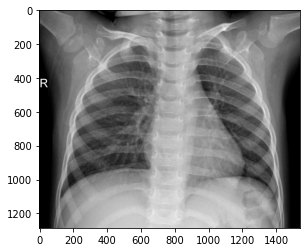

In [ ]:
train_normal_names[1]
# 'IM-0544-0001.jpeg'
img = mpimg.imread(os.path.join(train_normal_dir,'IM-0544-0001.jpeg'))
plt.imshow(img, cmap = 'gray')

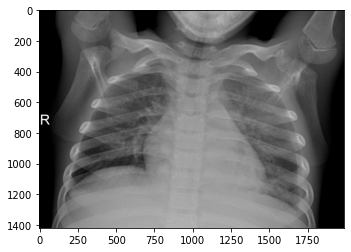

In [ ]:
train_pneumonia_names[1]
# 'person297_virus_614.jpeg'
img = mpimg.imread(os.path.join(train_pneumonia_dir, 'person297_virus_614.jpeg'))
plt.imshow(img, cmap = 'gray')

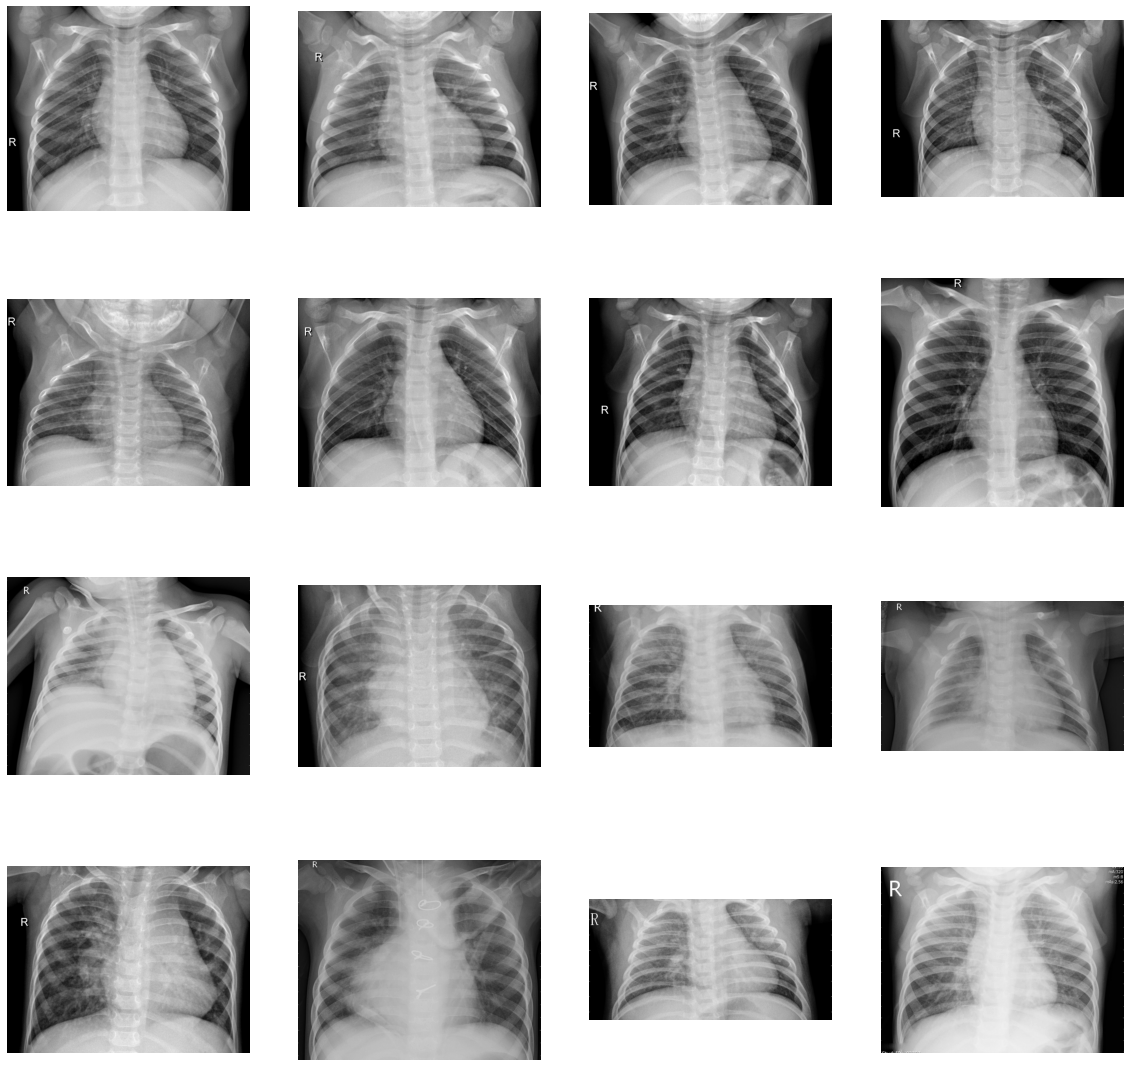

In [ ]:
# parâmetros para gráfico
nrows = 4
ncols = 4


fig = plt.gcf() # obter a imagem atual
fig.set_size_inches(20, 20) # tamanho da imagem

next_normal_pix = [os.path.join(train_normal_dir, fname) 
                    for fname in train_normal_names[0:8]]
next_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname)
                      for fname in train_pneumonia_names[0:8]]

for i, img_path in enumerate(next_normal_pix + next_pneumonia_pix):
  # configurar subplot
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img, cmap = 'gray')

plt.show() 

In [ ]:
img_size=100
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:  
            resized=cv2.resize(img,(img_size,img_size))
            #redimensionar a imagem para 100x100, pois precisamos de um tamanho comum fixo para todas as imagens no conjunto de dados
            data.append(resized)
            target.append(label_dict[category])
            #anexando a imagem e o rótulo (categorizado) à lista (conjunto de dados)
        except Exception as e:
            print('Exception:',e)
            #se qualquer exceção levantada, a exceção será impressa aqui. E passar para a próxima imagem

In [ ]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,3))
target=np.array(target)
from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

In [ ]:
new_target.shape

(5216, 2)

In [ ]:
data.shape

(5216, 100, 100, 3)

In [ ]:
data.shape[1:]

(100, 100, 3)

In [ ]:
model = tf.keras.models.Sequential([
  
    # Observe que a forma de entrada é o tamanho desejado da imagem 300x300 com 3 bytes de cor
    # Esta é a primeira convolução
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
  
    # A segunda convolução
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # A terceira convolução
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
   # A quarta convolução
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # A quinta convolução
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'), # 512 neurônio camada oculta
     # Apenas 1 neurônio de saída. Ele conterá um valor de 0-1, onde 0 para a classe ('normal') e 1 para a classe ('pneumonia')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       7

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    '/tmp/chest_xray/chest_xray/train/',
    target_size = (300,300),
    batch_size = 128,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    '/tmp/chest_xray/chest_xray/val/',
    target_size = (300, 300),
    batch_size = 128,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
# treiando o modelo
history = model.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = 10,
    validation_data = validation_generator
)

Epoch 1/10
10/10 [==============================] - 51s 2s/step - loss: 1.2402 - accuracy: 0.6955 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 16s 2s/step - loss: 0.5842 - accuracy: 0.7524 - val_loss: 0.7331 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 16s 2s/step - loss: 0.7939 - accuracy: 0.7156 - val_loss: 0.9484 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 17s 2s/step - loss: 0.4519 - accuracy: 0.7969 - val_loss: 0.9773 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 17s 2s/step - loss: 0.4001 - accuracy: 0.8313 - val_loss: 0.6340 - val_accuracy: 0.6250
Epoch 6/10
10/10 [==============================] - 16s 2s/step - loss: 0.3981 - accuracy: 0.8258 - val_loss: 0.5614 - val_accuracy: 0.6250
Epoch 7/10
10/10 [==============================] - 16s 2s/step - loss: 0.3470 - accuracy: 0.8602 - val_loss: 0.4134 - val_accuracy: 0.8125
Epoch 8/10
10/10 [==

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")

model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# carregar json e criar modelo
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# carregar pesos no novo modelo
loaded_model.load_weights("model.h5")
print("Modelo carregado do disco")

# avalia o modelo carregado nos dados de teste
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(validation_generator)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Modelo carregado do disco
1/1 [==============================] - 0s 468ms/step - loss: 0.2893 - accuracy: 0.8750
accuracy: 87.50%


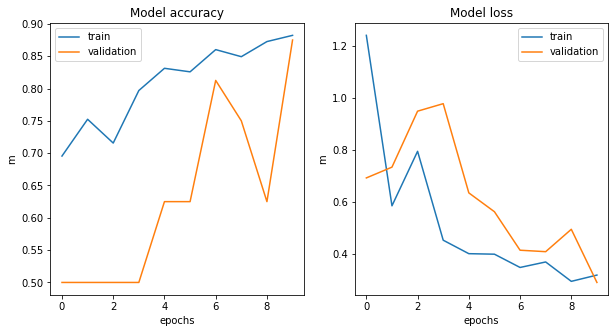

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

metric = ['accuracy', 'loss']
for i, m in enumerate(metric):
  ax[i].plot(history.history[m])
  ax[i].plot(history.history['val_'+ m])
  ax[i].set_title('Model {}'.format(m))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel('m')
  ax[i].legend(['train', 'validation'])

In [ ]:
#carregar novo conjunto de dados não visto
test_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_directory(
    '/tmp/chest_xray/chest_xray/val/',
    target_size = (300, 300),
    batch_size = 128, 
    class_mode = 'binary'
)

eval_result = model.evaluate_generator(test_generator, 16)
print('taxa de perda nos dados de avaliação :', eval_result[0])
print('taxa de acurácia nos dados de avaliação :', eval_result[1])

Found 16 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


taxa de perda nos dados de avaliação : 0.289332777261734
taxa de acurácia nos dados de avaliação : 0.875


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  # prever imagens
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300,300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis =0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)
  print("classe", classes[0])
  if classes[0]> 0.5:
    print(fn + ' is pneumonia')
    plt.imshow(img)
  else:
    print(fn + 'is normal')
    plt.imshow(img)